# Multi-Layer Perceptron

### Import Libraries


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np

### Settings

In [38]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Prepare the Data

In [39]:
# Define transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),                              # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))               # Normalize the pixel values to a range [-1, 1]
])

# Load the training dataset with transformations applied
train_dataset = datasets.MNIST(root='./data',         # Root directory where the dataset will be stored
                               train=True,             # Indicate that this is the training dataset
                               download=True,          # Download the dataset if not already downloaded
                               transform=transform)    # Apply transformations to the dataset

# Load the validation dataset with transformations applied
valid_dataset = datasets.MNIST(root='./data',         # Root directory where the dataset will be stored
                               train=True,             # Indicate that this is the training dataset
                               transform=transform)    # Apply transformations to the dataset

# Load the test dataset with transformations applied
test_dataset = datasets.MNIST(root='./data',          # Root directory where the dataset will be stored
                              train=False,             # Indicate that this is the test dataset
                              transform=transform)     # Apply transformations to the dataset

In [40]:
#validation_fraction is set to 0.1, indicating that 10% of the training dataset will be used for validation
validation_fraction = 0.1

num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

In [41]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [42]:


# Create a DataLoader for the training dataset
train_loader = DataLoader(dataset=train_dataset,      # The dataset to load
                          batch_size=BATCH_SIZE,      # Number of samples per batch
                          drop_last=True,            # Drop the last incomplete batch if its size is less than batch_size
                          sampler=train_sampler)     # Sampler for selecting batches

# Create a DataLoader for the validation dataset
valid_loader = DataLoader(dataset=valid_dataset,      # The dataset to load
                          batch_size=BATCH_SIZE,      # Number of samples per batch
                          sampler=valid_sampler)     # Sampler for selecting batches

# Create a DataLoader for the test dataset
test_loader = DataLoader(dataset=test_dataset,        # The dataset to load
                         batch_size=BATCH_SIZE,       # Number of samples per batch
                         shuffle=False)              # Do not shuffle the data (maintain the order)


### Data visualization

In [43]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


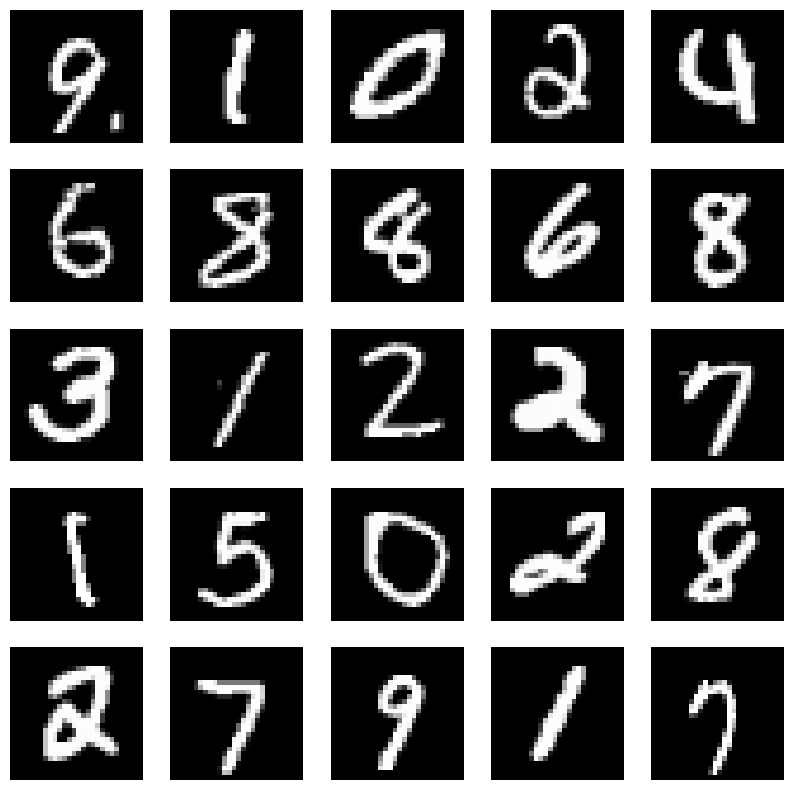

In [44]:

# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader):
    for j in range(25):
        plt.subplot(5, 5, j + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.axis('off')
    break
plt.show()


#### Defining the layers of the neural network

In [45]:


class MLP(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        
        # Define the layers of the neural network
        self.network = torch.nn.Sequential(
            # Flatten layer to convert input data into a 1D tensor
            torch.nn.Flatten(),
            # 1st hidden layer: Linear -> BatchNorm -> ReLU -> Dropout
            torch.nn.Linear(num_features, num_hidden_1),    # Fully connected layer
            torch.nn.BatchNorm1d(num_hidden_1),             # Batch normalization layer
            torch.nn.ReLU(),                                # ReLU activation function
            torch.nn.Dropout(0.5),                          # Dropout layer with 50% dropout rate
            
            # 2nd hidden layer: Linear -> BatchNorm -> ReLU -> Dropout
            torch.nn.Linear(num_hidden_1, num_hidden_2),    # Fully connected layer
            torch.nn.BatchNorm1d(num_hidden_2),             # Batch normalization layer
            torch.nn.ReLU(),                                # ReLU activation function
            torch.nn.Dropout(0.3),                          # Dropout layer with 30% dropout rate
            
            # Output layer: Linear
            torch.nn.Linear(num_hidden_2, num_classes)      # Fully connected layer (output layer)
        )
    def forward(self, x):
        logits = self.network(x)
        return logits




### Initialize Model, Loss Function, Optimizer, and Scheduler

In [46]:
# Define the MLP model
model = MLP(num_features=28*28,     # Number of input features (28x28 pixels image)
            num_hidden_1=128,       # Number of neurons in the first hidden layer
            num_hidden_2=64,        # Number of neurons in the second hidden layer
            num_classes=10)         # Number of output classes (digits 0-9)

# Move the model to the specified device (e.g., GPU or CPU)
model = model.to(DEVICE)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Define your optimizer (using Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(),    # Parameters to optimize (weights and biases)
#                             lr=0.1,                # Learning rate
#                             momentum=0.9,          # Momentum for SGD optimizer
#                             weight_decay=0.0001)   # L2 regularization (weight decay)

# Define the learning rate scheduler
# Create the scheduler with exponential decay
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


#### Training and Testing

In [47]:
def compute_accuracy(data_loader):
    # Disable gradient computation
    with torch.no_grad():
        # Initialize variables to count correct predictions and total examples
        correct_pred, num_examples = 0, 0
        
        # Iterate over the data loader
        for i, (features, targets) in enumerate(data_loader):
            # Move features and targets to the specified device (e.g., GPU or CPU)
            features = features.to(DEVICE)
            targets = targets.float().to(DEVICE)
            
            # Forward pass: compute model predictions
            logits = model(features)
            
            # Get the predicted labels by selecting the index of the maximum value in the logits
            _, predicted_labels = torch.max(logits, 1)
            
            # Update the count of total examples
            num_examples += targets.size(0)
            
            # Update the count of correct predictions by comparing predicted labels with targets
            correct_pred += (predicted_labels == targets).sum()
    
    # Calculate the accuracy by dividing the number of correct predictions by the total number of examples
    return correct_pred.float() / num_examples * 100


In [48]:
# Initialize lists to store training metrics
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

# Record the starting time
start_time = time.time()

# Iterate over the specified number of epochs
for epoch in range(NUM_EPOCHS):
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data loader
    for batch_idx, (features, targets) in enumerate(train_loader):
        # Move features and targets to the specified device (e.g., GPU or CPU)
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        
        # Forward pass: compute logits (predictions) using the model
        logits = model(features)
        
        # Compute the loss using the specified loss function (criterion)
        loss = criterion(logits, targets)
        
        # Zero the gradients (reset gradients to zero) to prevent accumulation
        optimizer.zero_grad()
        
        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()
        
        # Update model parameters (weights and biases) using the specified optimizer
        optimizer.step()
        
        # Log the minibatch loss
        minibatch_loss_list.append(loss.item())
        
        # Print training progress periodically
        logging_interval = 100
        if not batch_idx % logging_interval:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss:.4f}')
    
    # Set the model to evaluation mode (no gradient computation)
    model.eval()
    
    # Compute accuracy on training and validation datasets
    with torch.no_grad(): # Disable gradient computation to save memory during inference
        train_acc = compute_accuracy(train_loader)
        valid_acc = compute_accuracy(valid_loader)
        
        # Print training and validation accuracy for the current epoch
        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train: {train_acc:.2f}% | Validation: {valid_acc:.2f}%')
        
        # Store training and validation accuracy for visualization
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())
    
    # Adjust the learning rate based on the last minibatch loss
    scheduler.step(minibatch_loss_list[-1])

# Calculate the total training time
elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Compute accuracy on the test dataset
test_acc = compute_accuracy(test_loader)
print(f'Test accuracy: {test_acc:.2f}%')


Epoch: 1/20 | Batch 0/843 | Loss: 2.5046
Epoch: 1/20 | Batch 100/843 | Loss: 0.6279
Epoch: 1/20 | Batch 200/843 | Loss: 0.6091
Epoch: 1/20 | Batch 300/843 | Loss: 0.6032
Epoch: 1/20 | Batch 400/843 | Loss: 0.4522
Epoch: 1/20 | Batch 500/843 | Loss: 0.3503
Epoch: 1/20 | Batch 600/843 | Loss: 0.3267
Epoch: 1/20 | Batch 700/843 | Loss: 0.3097
Epoch: 1/20 | Batch 800/843 | Loss: 0.2846
Epoch: 1/20 | Train: 94.76% | Validation: 95.53%
Epoch: 2/20 | Batch 0/843 | Loss: 0.3679


/Users/titolanna/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2/20 | Batch 100/843 | Loss: 0.1921
Epoch: 2/20 | Batch 200/843 | Loss: 0.3706
Epoch: 2/20 | Batch 300/843 | Loss: 0.4669
Epoch: 2/20 | Batch 400/843 | Loss: 0.2081
Epoch: 2/20 | Batch 500/843 | Loss: 0.4406
Epoch: 2/20 | Batch 600/843 | Loss: 0.2359
Epoch: 2/20 | Batch 700/843 | Loss: 0.3751
Epoch: 2/20 | Batch 800/843 | Loss: 0.3120
Epoch: 2/20 | Train: 95.84% | Validation: 96.52%
Epoch: 3/20 | Batch 0/843 | Loss: 0.2544
Epoch: 3/20 | Batch 100/843 | Loss: 0.3759
Epoch: 3/20 | Batch 200/843 | Loss: 0.2618
Epoch: 3/20 | Batch 300/843 | Loss: 0.1872
Epoch: 3/20 | Batch 400/843 | Loss: 0.2315
Epoch: 3/20 | Batch 500/843 | Loss: 0.1387
Epoch: 3/20 | Batch 600/843 | Loss: 0.3952
Epoch: 3/20 | Batch 700/843 | Loss: 0.1599
Epoch: 3/20 | Batch 800/843 | Loss: 0.2532
Epoch: 3/20 | Train: 96.58% | Validation: 96.88%
Epoch: 4/20 | Batch 0/843 | Loss: 0.6131
Epoch: 4/20 | Batch 100/843 | Loss: 0.2080
Epoch: 4/20 | Batch 200/843 | Loss: 0.2711
Epoch: 4/20 | Batch 300/843 | Loss: 0.1832
Epo

#### Visualization 

Text(0, 0.5, 'Loss')

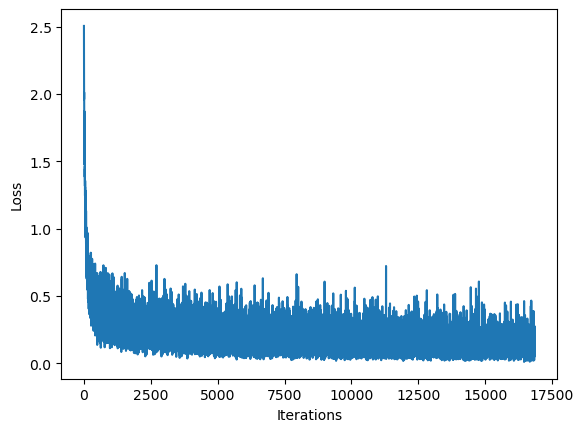

In [49]:
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

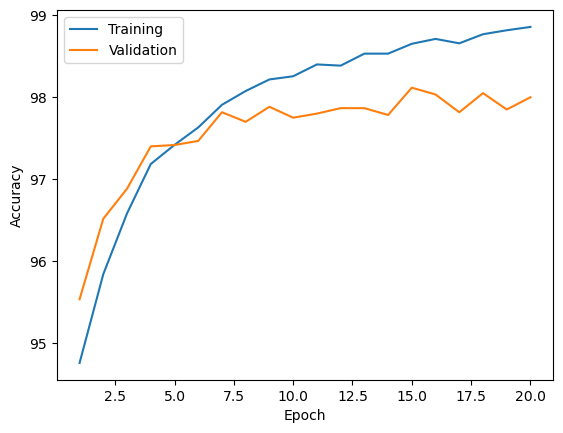

In [50]:

# Calculate the number of epochs based on the length of the training accuracy list
num_epochs = len(train_acc_list)

# Plot the training and validation accuracy curves
plt.plot(np.arange(1, num_epochs+1),    # x-axis: epoch numbers
         train_acc_list,                 # y-axis: training accuracy
         label='Training')              # label for the training curve

plt.plot(np.arange(1, num_epochs+1),    # x-axis: epoch numbers
         valid_acc_list,                 # y-axis: validation accuracy
         label='Validation')            # label for the validation curve

# Set labels for the x-axis and y-axis
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display legend to differentiate between training and validation curves
plt.legend()
